In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

In [4]:
# 1. Load Data
df = pd.read_csv('../data/diabetes_data/diabetes.csv')

In [5]:
# 2. Remove null columns
df = df.dropna(axis=1, how='all')

In [6]:
# 3. Clean invalid zeros (domain columns)
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_to_fix:
    df[col].replace(0, np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_22024\3198928681.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(0, np.nan, inplace=True)


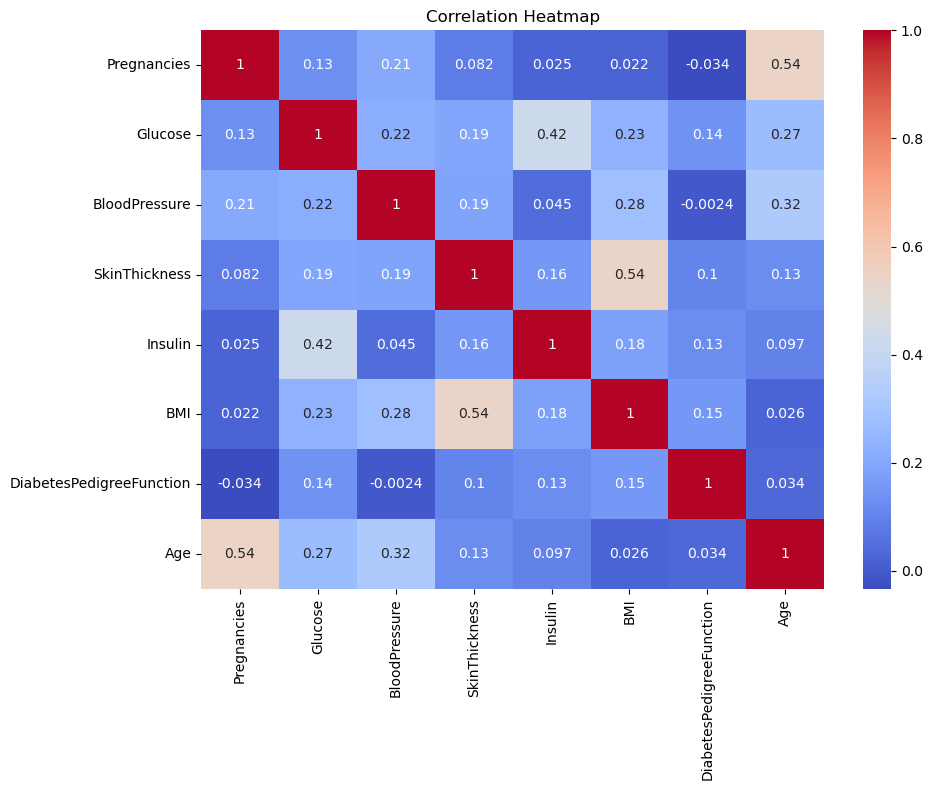

In [7]:
# 4. EDA: Heatmap (correlations)
plt.figure(figsize=(10,8))
sns.heatmap(df.drop('Outcome', axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

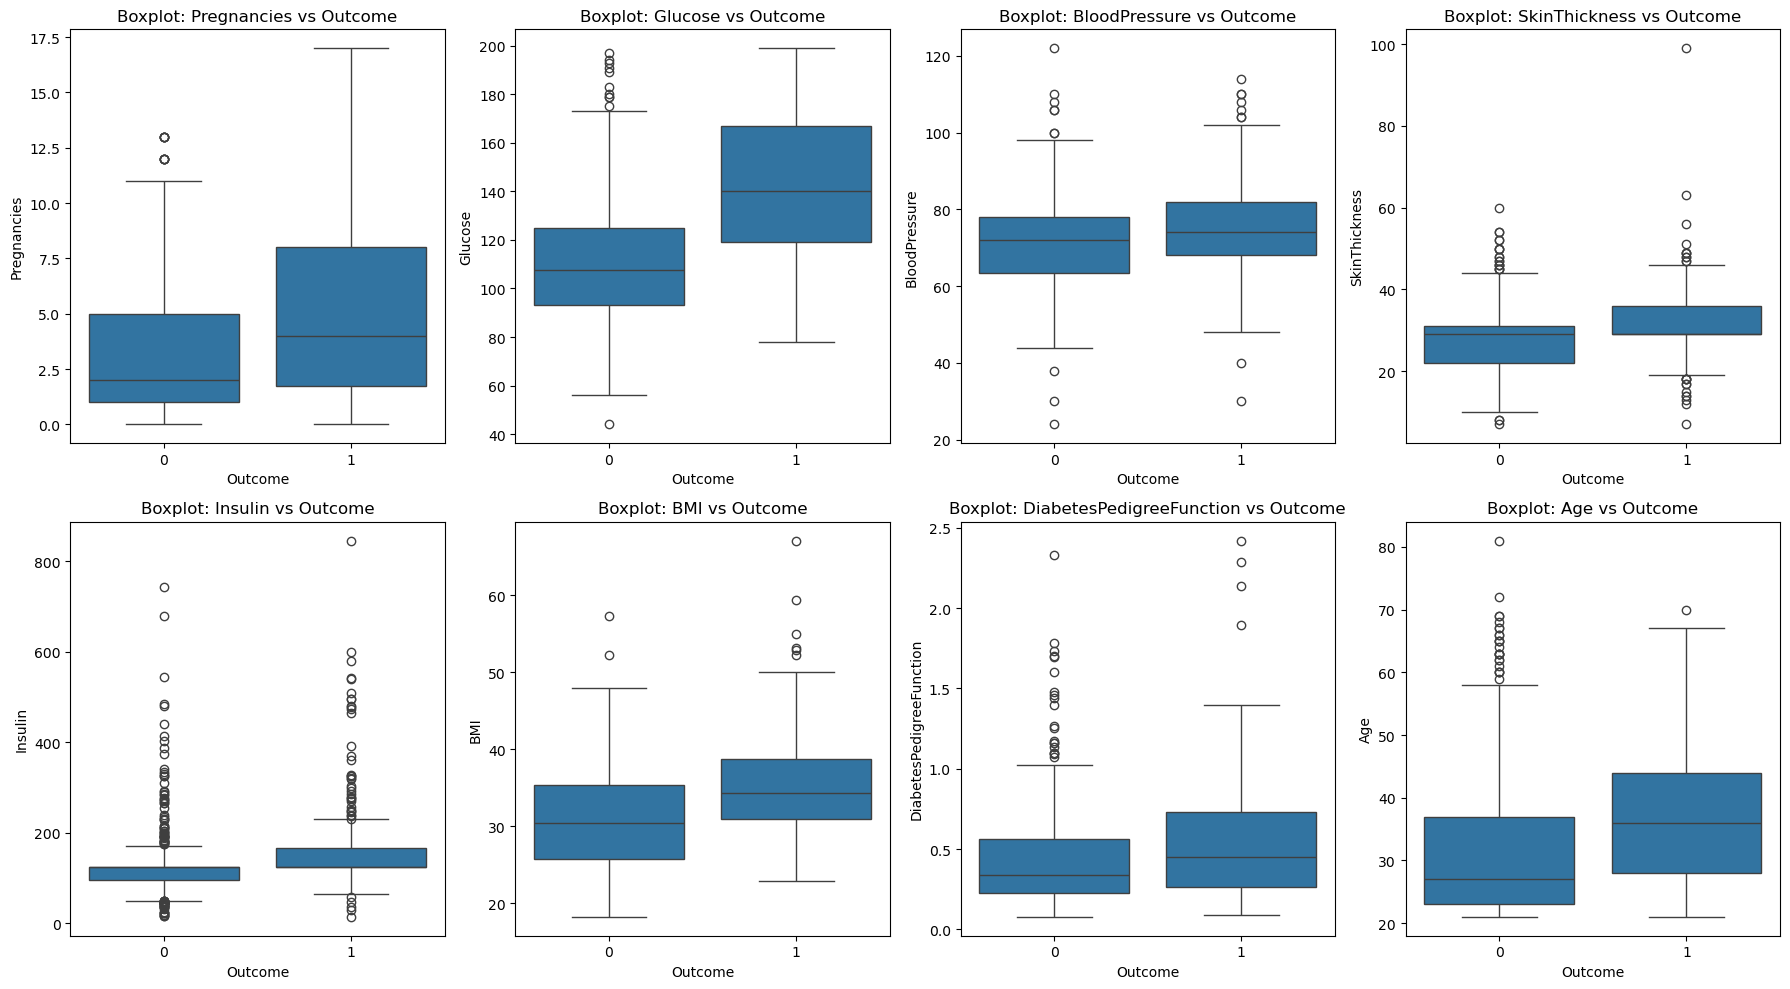

In [8]:
# Boxplots for all features
plt.figure(figsize=(18, 10))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(2,4,i)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'Boxplot: {col} vs Outcome')
plt.tight_layout()
plt.show()

In [9]:
# 5. Feature Engineering
df['BMI_Age_Ratio'] = df['BMI'] / (df['Age'] + 1)
df['Glucose_Pedigree'] = df['Glucose'] * df['DiabetesPedigreeFunction']
df['BP_Insulin'] = df['BloodPressure'] * df['Insulin']

In [10]:
# 6. Prepare data
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [11]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 8. Pipeline: StandardScaler + RidgeClassifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeClassifier())
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# Use decision_function for RidgeClassifier for ROC/AUC
y_prob = pipe.decision_function(X_test)

In [13]:
# 9. Evaluation and Visualization
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.83        99
           1       0.70      0.60      0.65        55

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154

Test Accuracy: 0.7662337662337663


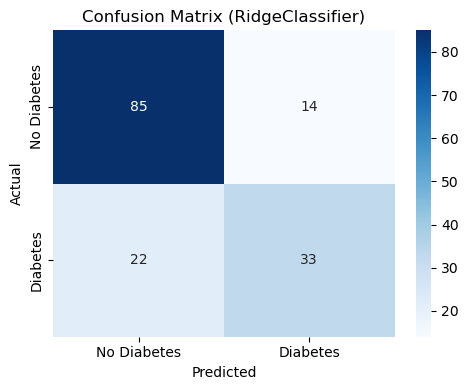

In [14]:
# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RidgeClassifier)')
plt.tight_layout()
plt.show()

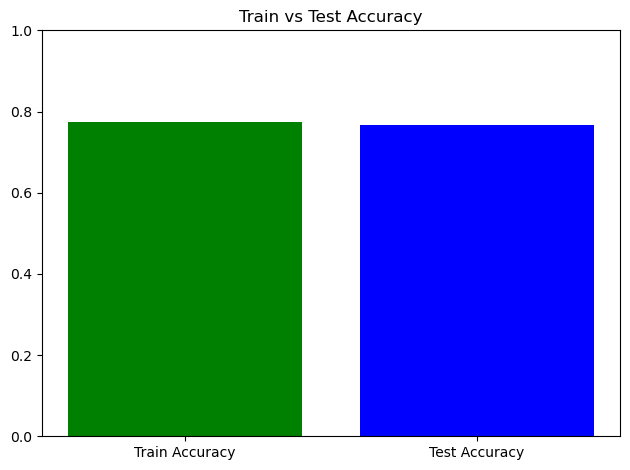

In [15]:
# Accuracy
train_acc = accuracy_score(y_train, pipe.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['green','blue'])
plt.ylim(0,1)
plt.title('Train vs Test Accuracy')
plt.tight_layout()
plt.show()

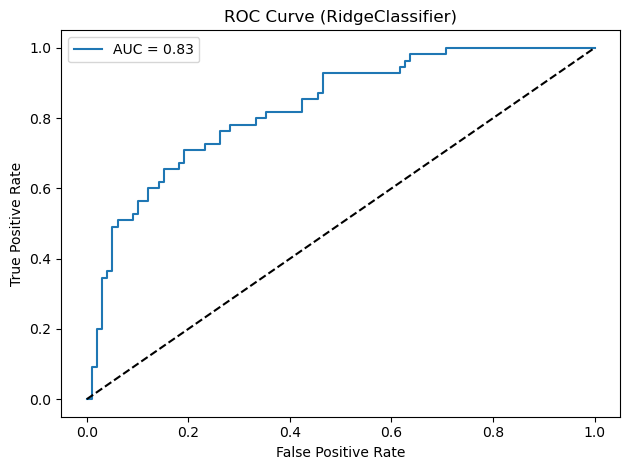

In [16]:
# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RidgeClassifier)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

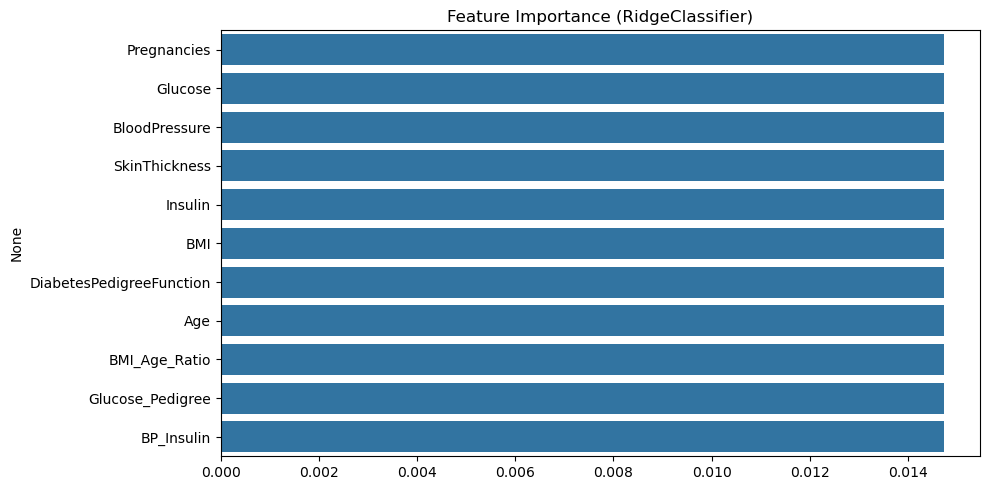

In [17]:
# Feature importance (from RidgeClassifier coef_)
ridge_clf = pipe.named_steps['ridge']
importance = np.abs(ridge_clf.coef_[0])
feature_names = X.columns
plt.figure(figsize=(10,5))
sns.barplot(x=importance, y=feature_names)
plt.title('Feature Importance (RidgeClassifier)')
plt.tight_layout()
plt.show()

In [18]:
# 10. Save pipeline model
joblib.dump(pipe, 'ridge_classifier_diabetes_pipeline.pkl')
print("Pipeline saved as 'ridge_classifier_diabetes_pipeline.pkl'")

Pipeline saved as 'ridge_classifier_diabetes_pipeline.pkl'


To use for inference later:
pipe = joblib.load('ridge_classifier_diabetes_pipeline.pkl')
y_pred_new = pipe.predict(X_new)